This notebook shows how to solve the problem as a multi-class classification by finding candidate points based on geographic location.<br>
Similarity as a string, such as edit distance and LCS (Longest Common Subsequence), was used for the features of the candidate points.<br>
<br>
Inference is made on test data only, but the code for training is left commented out.<br>
<br>
In addition, making the matches bidirectional as a post-processing step improved the score by about 1%.<br>
<br>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import gc
import random
from glob import glob
from sklearn.model_selection import GroupKFold, KFold, StratifiedKFold
import warnings
import seaborn as sns
import pickle
import json
import re
import time
import sys
from requests import get
import multiprocessing
import joblib
if "google.colab" in sys.modules:
    !pip uninstall lightgbm -y
    !pip install lightgbm==3.3.1

class CFG:
    seed = 46
    target = "point_of_interest"
    n_neighbors = 10
    n_splits = 3
    debug = False
    save = False

    expID = ""
    if "google.colab" in sys.modules:
        expID = get("http://172.28.0.2:9000/api/sessions").json()[0]["name"].split(".")[0].split("-")[0]

random.seed(CFG.seed)
os.environ["PYTHONHASHSEED"] = str(CFG.seed)
np.random.seed(CFG.seed)

plt.rcParams["font.size"] = 13
warnings.filterwarnings('ignore')

%cd /content/drive/MyDrive/Kaggle/Foursquare/Notebook

Found existing installation: lightgbm 3.3.1
Uninstalling lightgbm-3.3.1:
  Successfully uninstalled lightgbm-3.3.1
  Using cached lightgbm-3.3.1-py3-none-manylinux1_x86_64.whl (2.0 MB)
/content/drive/MyDrive/Kaggle/Foursquare/Notebook


In [ ]:
OUTPUT_DIR = '../Output'
if not os.path.exists(os.path.join(OUTPUT_DIR, CFG.expID)):
    os.makedirs(os.path.join(OUTPUT_DIR, CFG.expID))

In [ ]:
train = pd.read_csv("../Input/train.csv")
test = pd.read_csv("../Input/test.csv")
test[CFG.target] = "TEST"

train.head(1)

,id,name,latitude,longitude,address,city,state,zip,country,url,phone,categories,point_of_interest
0,E_000001272c6c5d,Café Stad Oudenaarde,50.859975,3.634196,Abdijstraat,Nederename,Oost-Vlaanderen,9700,BE,NaN,NaN,Bars,P_677e840bb6fc7e


In [ ]:
if CFG.debug:
    train = train[:10000]

# Devide Train Data into about 600K×2

In [ ]:
kf = GroupKFold(n_splits=2)
for i, (trn_idx, val_idx) in enumerate(kf.split(train, train[CFG.target], train[CFG.target])):
    train.loc[val_idx, "set"] = i
train["set"].value_counts()

1.0    569406
0.0    569406
Name: set, dtype: int64

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

def add_neighbor_features(df):
    dfs = []
    columns = ['id', 'name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']
    for c in columns:
        if c != "id":
            df[c] = df[c].astype(str).str.lower()

    for country, country_df in tqdm(df.groupby("country")):
        country_dfs = []
        country_df = country_df.reset_index(drop=True)
        
        knn = KNeighborsRegressor(n_neighbors=min(len(country_df), CFG.n_neighbors), 
                                  metric='haversine', n_jobs=-1)
        knn.fit(country_df[['latitude','longitude']], country_df.index)
        dists, nears = knn.kneighbors(country_df[['latitude','longitude']], return_distance=True)
        targets = country_df[CFG.target].values
        for i in range(min(len(country_df), CFG.n_neighbors)):
            country_df_ = country_df.copy()
            country_df_[f"d_near"] = dists[:, i]
            country_df_[f"near_target"] = targets[nears[:, i]]
            for c in columns:
                country_df_[f"near_{c}"] = country_df_[c].values[nears[:, i]]
            country_dfs.append(country_df_)
        country_df = pd.concat(country_dfs)
        dfs.append(country_df)
    df = pd.concat(dfs).reset_index(drop=True)
    return df

train = pd.concat([
    add_neighbor_features(train[train["set"]==0]), 
    add_neighbor_features(train[train["set"]==1]), 
])
test = add_neighbor_features(test)

train.head(1)

  0%|          | 0/210 [00:00<?, ?it/s]

  0%|          | 0/211 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_id,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories
0,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,E_1104d3664585a4,mamá maría,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,nan,"italian restaurants, pizza places"


In [ ]:
train = train[train['id'] != train['near_id']]
test = test[test['id'] != test['near_id']]

# Create Target

In [ ]:
train["target"] = 0
train.loc[train[CFG.target]==train[f"near_target"], "target"] = 1
train.head()

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_name,near_address,near_city,near_state,near_zip,near_country,near_url,near_phone,near_categories,target
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,mamá maría,"av. meritxell, 25",andorra la vella,andorra,ad500,ad,nan,+376869996,"italian restaurants, pizza places",1
13,E_1514d74b987ae1,ahotels piolets park & spa,42.578021,1.663907,"carretera de soldeu, s/n",soldeu,andorra,ad100,ad,http://www.ahotels.com/,...,ontbijtroom piolets park,nan,soldeu,andorra,nan,ad,nan,nan,buffets,1
14,E_206f06060f193d,la borda xica,42.571045,1.487248,cap del carrer,la massana,nan,nan,ad,nan,...,vallnord - pal arinsal (sector arinsal),carretera d'arinsal. ed. comallemple.,arinsal,arinsal,ad400,ad,http://www.vallnord.com,737020,ski areas,0
15,E_20b7920b07557d,"escola de esquí el forn de canillo, grandvalira",42.556103,1.616165,"el forn de canillo, s/n",canillo,canillo,ad100,ad,nan,...,el forn de canillo,nan,canillo,nan,nan,ad,nan,nan,ski areas,1
16,E_4a34a5012e88c3,pic negre 11,42.546688,1.513963,nan,la massana,nan,ad400,ad,nan,...,pic negre 12,sanantoni,la massana,nan,ad400,ad,nan,737745,sporting goods shops,0


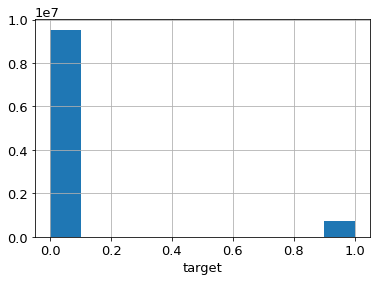

In [ ]:
plt.hist(train["target"])
plt.grid()
plt.xlabel("target")
plt.show()

# Check Maximum Score

In [ ]:
# https://www.kaggle.com/code/columbia2131/foursquare-iou-metrics
def get_id2poi(input_df: pd.DataFrame) -> dict:
    return dict(zip(input_df['id'], input_df['point_of_interest']))

def get_poi2ids(input_df: pd.DataFrame) -> dict:
    return input_df.groupby('point_of_interest')['id'].apply(set).to_dict()

id2poi = get_id2poi(train)
poi2ids = get_poi2ids(train)

In [ ]:
def get_score(id2ids: dict):
    scores = []
    precisions = []
    recalls = []
    for id_str in train['id'].unique():
        if id_str in id2ids:
            preds = id2ids[id_str]
        else:
            preds = set()
        preds.add(id_str)
        targets = poi2ids[id2poi[id_str]]
        score = len((targets & preds)) / len((targets | preds))
        if len(preds) == 0:
            precision = 0
        else:
            precision = len((targets & preds)) / len(preds)
        recall = len((targets & preds)) / len(targets)
        scores.append(score)
        precisions.append(precision)
        recalls.append(recall)
    scores = np.array(scores)
    precisions = np.array(precisions)
    recalls = np.array(recalls)
    return scores.mean(), precisions.mean(), recalls.mean()

In [ ]:
id2ids = train[train[CFG.target] == train['near_target']].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(score)

0.8904038900654864


In [ ]:
# del train
# gc.collect()

# Feature Engineering

In [ ]:
if "google.colab" in sys.modules:
    !pip install Levenshtein

In [ ]:
%load_ext Cython

In [ ]:
%%cython
def LCS(str S, str T):
    cdef int i, j
    cdef list dp = [[0] * (len(T) + 1) for _ in range(len(S) + 1)]
    for i in range(len(S)):
        for j in range(len(T)):
            dp[i + 1][j + 1] = max(dp[i][j] + (S[i] == T[j]), dp[i + 1][j], dp[i][j + 1], dp[i + 1][j + 1])
    return dp[len(S)][len(T)]

In [ ]:
import Levenshtein
import difflib

def _add_distance_features(args):
    _, df = args

    columns = ['name', 'address', 'city', 'state',
           'zip', 'country', 'url', 'phone', 'categories']

    for c in columns:
        geshs = []
        levens = []
        jaros = []
        lcss = []
        for str1, str2 in df[[c, f"near_{c}"]].values.astype(str):
            if str1==str1 and str2==str2:
                geshs.append(difflib.SequenceMatcher(None, str1, str2).ratio())
                levens.append(Levenshtein.distance(str1, str2))
                jaros.append(Levenshtein.jaro_winkler(str1, str2))
                lcss.append(LCS(str(str1), str(str2)))
            else:
                geshs.append(-1)
                levens.append(-1)
                jaros.append(-1)
        df[f"near_{c}_gesh"] = geshs
        df[f"near_{c}_leven"] = levens
        df[f"near_{c}_jaro"] = jaros
        df[f"near_{c}_lcs"] = lcss
        
        if not c in ['country', "phone", "zip"]:
            df[f"{c}_len"] = df[c].astype(str).map(len)
            df[f"near_{c}_len"] = df[f"near_{c}"].astype(str).map(len)
            df[f"near_{c}_nleven"] = df[f"near_{c}_leven"] / df[[f"near_{c}_len", f"{c}_len"]].max(axis=1)
            df[f"near_{c}_nlcsi"] = df[f"near_{c}_lcs"] / df[f"near_{c}_len"]
            df[f"near_{c}_nlcs0"] = df[f"near_{c}_lcs"] / df[f"{c}_len"]
    return df

def add_distance_features(df):
    processes = multiprocessing.cpu_count()
    with multiprocessing.Pool(processes=processes) as pool:
        dfs = pool.imap_unordered(_add_distance_features, df.groupby('country'))
        dfs = tqdm(dfs)
        dfs = list(dfs)
    df = pd.concat(dfs)
    return df

train_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "train_distance_features.csv"))
test_distance_features_path = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "test_distance_features.csv"))

if CFG.save and (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train = pd.read_csv(train_distance_features_path)
    test = pd.read_csv(test_distance_features_path)
else:
    train = add_distance_features(train)
    test = add_distance_features(test)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [ ]:
display(train.head(1))
display(test.head(1))

,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
12,E_1104d3664585a4,mamá maría,42.508166,1.525205,"av. meritxell, 25",andorra la vella,parròquia d'andorra la vella,nan,ad,nan,...,0,1.0,0,1.0,33,33,33,0.0,1.0,1.0


,id,name,latitude,longitude,address,city,state,zip,country,url,...,near_phone_lcs,near_categories_gesh,near_categories_leven,near_categories_jaro,near_categories_lcs,categories_len,near_categories_len,near_categories_nleven,near_categories_nlcsi,near_categories_nlcs0
2,E_001b6bad66eb98,"gelora sriwijaya, jaka baring sport city",-3.014675,104.794374,nan,nan,nan,nan,id,nan,...,3,0.695652,7,0.461111,8,8,15,0.466667,0.533333,1.0


In [ ]:
if CFG.save and not (os.path.exists(train_distance_features_path) and os.path.exists(test_distance_features_path)):
    train.to_csv(train_distance_features_path, index=False)
    test.to_csv(test_distance_features_path, index=False)

# Delete Unusing Columns (just for avoiding OOM)

In [ ]:
features = []

columns = ['name', 'address', 'city', 'state',
       'zip', 'country', 'url', 'phone', 'categories']

features.append(f"d_near")
for c in columns:        
    features += [f"near_{c}_gesh", f"near_{c}_jaro", f"near_{c}_lcs"]
    if c in ['country', "phone", "zip"]:
        features += [f"near_{c}_leven"]
    else:
        features += [f"near_{c}_len", f"near_{c}_nleven", f"near_{c}_nlcsi", f"near_{c}_nlcs0"]

for f in features:
#     assert f in train.columns
    if f not in test.columns:
        test[f] = np.nan

print(features)

['d_near', 'near_name_gesh', 'near_name_jaro', 'near_name_lcs', 'near_name_len', 'near_name_nleven', 'near_name_nlcsi', 'near_name_nlcs0', 'near_address_gesh', 'near_address_jaro', 'near_address_lcs', 'near_address_len', 'near_address_nleven', 'near_address_nlcsi', 'near_address_nlcs0', 'near_city_gesh', 'near_city_jaro', 'near_city_lcs', 'near_city_len', 'near_city_nleven', 'near_city_nlcsi', 'near_city_nlcs0', 'near_state_gesh', 'near_state_jaro', 'near_state_lcs', 'near_state_len', 'near_state_nleven', 'near_state_nlcsi', 'near_state_nlcs0', 'near_zip_gesh', 'near_zip_jaro', 'near_zip_lcs', 'near_zip_leven', 'near_country_gesh', 'near_country_jaro', 'near_country_lcs', 'near_country_leven', 'near_url_gesh', 'near_url_jaro', 'near_url_lcs', 'near_url_len', 'near_url_nleven', 'near_url_nlcsi', 'near_url_nlcs0', 'near_phone_gesh', 'near_phone_jaro', 'near_phone_lcs', 'near_phone_leven', 'near_categories_gesh', 'near_categories_jaro', 'near_categories_lcs', 'near_categories_len', 'near_

In [ ]:
train = train[features + [CFG.target, "target", "id", "near_id"]]
test = test[features + ["id", "near_id"]]

train[features] = train[features].astype(np.float16)
test[features] = test[features].astype(np.float16)

train["target"] = train["target"].fillna(0)

train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

for _ in range(5):
    gc.collect()

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10248613 entries, 0 to 10248612
Data columns (total 59 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   d_near                  float16
 1   near_name_gesh          float16
 2   near_name_jaro          float16
 3   near_name_lcs           float16
 4   near_name_len           float16
 5   near_name_nleven        float16
 6   near_name_nlcsi         float16
 7   near_name_nlcs0         float16
 8   near_address_gesh       float16
 9   near_address_jaro       float16
 10  near_address_lcs        float16
 11  near_address_len        float16
 12  near_address_nleven     float16
 13  near_address_nlcsi      float16
 14  near_address_nlcs0      float16
 15  near_city_gesh          float16
 16  near_city_jaro          float16
 17  near_city_lcs           float16
 18  near_city_len           float16
 19  near_city_nleven        float16
 20  near_city_nlcsi         float16
 21  near_city_nlcs0         float

# Split Folds

In [ ]:
kf = StratifiedKFold(n_splits=CFG.n_splits, shuffle=True, random_state=CFG.seed)
for i, (trn_idx, val_idx) in tqdm(enumerate(kf.split(train, train["target"], train["target"]))):
    train.loc[val_idx, "fold"] = i

0it [00:00, ?it/s]

# Model Learning

In [ ]:
import lightgbm as lgbm

def fit_lgbm(X, y, params=None, es_rounds=20, seed=42, N_SPLITS=5, 
             n_class=None, model_dir=None, folds=None):
    models = []
    oof = np.zeros((len(y), 2), dtype=np.float64)
    
    for i in tqdm(range(CFG.n_splits)):
        print(f"== fold {i} ==")
        trn_idx = folds!=i
        val_idx = folds==i
        X_train, y_train = X[trn_idx], y.iloc[trn_idx]
        X_valid, y_valid = X.iloc[val_idx], y.iloc[val_idx]

        if model_dir is None:
            model = lgbm.LGBMClassifier(**params)
            model.fit(
                X_train, y_train, 
                eval_set=[(X_valid, y_valid)],  
                early_stopping_rounds=es_rounds, 
                eval_metric='binary',  
    #             verbose=-1)
                verbose=50)
        else:
            with open(f'{model_dir}/lgbm_fold{i}.pkl', 'rb') as f:
                model = pickle.load(f)
            
        pred = model.predict_proba(X_valid)
        oof[val_idx] = pred
        models.append(model)
        
        file = os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))
        pickle.dump(model, open(file, 'wb'))
        print()

    cv = (oof.argmax(axis=-1) == y).mean()
    print(f"CV-accuracy: {cv}")

    return oof, models

def inference_lgbm(models, feat_df):
    pred = np.array([model.predict_proba(feat_df) for model in models])
    pred = np.mean(pred, axis=0)
    return pred

In [ ]:
params = {
    'objective': "binary",
    'learning_rate': 0.2,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,

    'max_depth': 7,   
    'num_leaves': 35, 
    'n_estimators': 1000000, 
    "colsample_bytree": 0.9,
}

if os.path.exists(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, 'lgbm_fold0.pkl'))):
    models = [joblib.load(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, f'lgbm_fold{i}.pkl'))) for i in range(CFG.n_splits)]
    oof = pd.read_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")))
    oof = oof.values
else:
    oof, models = fit_lgbm(train[features], train["target"].astype(int), 
                          params=params, n_class=2, 
                          N_SPLITS=CFG.n_splits, folds=train["fold"].values)
    pd.DataFrame(oof).to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "oof.csv")), index = False)
pred = inference_lgbm(models, test[features])

  0%|          | 0/3 [00:00<?, ?it/s]

== fold 0 ==
[50]	valid_0's binary_logloss: 0.0853695
[100]	valid_0's binary_logloss: 0.0821939
[150]	valid_0's binary_logloss: 0.0806313
[200]	valid_0's binary_logloss: 0.079584
[250]	valid_0's binary_logloss: 0.0788231
[300]	valid_0's binary_logloss: 0.0782549
[350]	valid_0's binary_logloss: 0.0777226
[400]	valid_0's binary_logloss: 0.0772418
[450]	valid_0's binary_logloss: 0.076762
[500]	valid_0's binary_logloss: 0.0763459
[550]	valid_0's binary_logloss: 0.0760226
[600]	valid_0's binary_logloss: 0.0758093
[650]	valid_0's binary_logloss: 0.0755001
[700]	valid_0's binary_logloss: 0.075261
[750]	valid_0's binary_logloss: 0.0750291
[800]	valid_0's binary_logloss: 0.0747854
[850]	valid_0's binary_logloss: 0.0745952
[900]	valid_0's binary_logloss: 0.0743745
[950]	valid_0's binary_logloss: 0.0741748
[1000]	valid_0's binary_logloss: 0.0739744
[1050]	valid_0's binary_logloss: 0.0738311
[1100]	valid_0's binary_logloss: 0.0736701
[1150]	valid_0's binary_logloss: 0.0735044
[1200]	valid_0's bina

In [ ]:
train["pred"] = oof[:, -1]

In [ ]:
train["max_pred"] = train["id"].map(dict(train.groupby("id")["pred"].max()))

# Check CV

In [ ]:
!pip install optuna

In [ ]:
import optuna

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > x)].groupby('id')['near_id'].apply(lambda x: set(x))
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 13:00:04,331] A new study created in memory with name: no-name-427b98b5-300c-44e3-87a7-da564757f56f
[I 2022-05-14 13:00:27,842] Trial 0 finished with value: 0.8090391269322196 and parameters: {'threshold': 0.24671171040803264}. Best is trial 0 with value: 0.8090391269322196.


CV: 0.809039, precision: 0.954681, recall: 0.846345


[I 2022-05-14 13:00:47,055] Trial 1 finished with value: 0.8103728165941184 and parameters: {'threshold': 0.6658641471837208}. Best is trial 1 with value: 0.8103728165941184.


CV: 0.810373, precision: 0.986069, recall: 0.821725


[I 2022-05-14 13:01:10,342] Trial 2 finished with value: 0.810275257607692 and parameters: {'threshold': 0.26700915730769315}. Best is trial 1 with value: 0.8103728165941184.


CV: 0.810275, precision: 0.957343, recall: 0.845404


[I 2022-05-14 13:01:37,164] Trial 3 finished with value: 0.7664845839235599 and parameters: {'threshold': 0.039040457389965755}. Best is trial 1 with value: 0.8103728165941184.


CV: 0.766485, precision: 0.886913, recall: 0.856089


[I 2022-05-14 13:01:54,630] Trial 4 finished with value: 0.7893813056461584 and parameters: {'threshold': 0.8794976631086763}. Best is trial 1 with value: 0.8103728165941184.


CV: 0.789381, precision: 0.994865, recall: 0.793484


[I 2022-05-14 13:02:19,852] Trial 5 finished with value: 0.7923614128548007 and parameters: {'threshold': 0.10925891507611396}. Best is trial 1 with value: 0.8103728165941184.


CV: 0.792361, precision: 0.925862, recall: 0.852559


[I 2022-05-14 13:02:32,996] Trial 6 finished with value: 0.7148539071751617 and parameters: {'threshold': 0.9940843582393478}. Best is trial 1 with value: 0.8103728165941184.


CV: 0.714854, precision: 0.999617, recall: 0.715164


[I 2022-05-14 13:02:55,757] Trial 7 finished with value: 0.8143252634861721 and parameters: {'threshold': 0.38886760692472055}. Best is trial 7 with value: 0.8143252634861721.


CV: 0.814325, precision: 0.969404, recall: 0.839534


[I 2022-05-14 13:03:14,784] Trial 8 finished with value: 0.8123407310366811 and parameters: {'threshold': 0.6177109261901884}. Best is trial 7 with value: 0.8143252634861721.


CV: 0.812341, precision: 0.983762, recall: 0.825613


[I 2022-05-14 13:03:35,678] Trial 9 finished with value: 0.8144140850370506 and parameters: {'threshold': 0.39439203840448844}. Best is trial 9 with value: 0.8144140850370506.


CV: 0.814414, precision: 0.969858, recall: 0.839253


[I 2022-05-14 13:03:56,207] Trial 10 finished with value: 0.8144313211057443 and parameters: {'threshold': 0.5181333776416107}. Best is trial 10 with value: 0.8144313211057443.


CV: 0.814431, precision: 0.978301, recall: 0.832256


[I 2022-05-14 13:04:18,779] Trial 11 finished with value: 0.8147558755215882 and parameters: {'threshold': 0.4899670373195053}. Best is trial 11 with value: 0.8147558755215882.


CV: 0.814756, precision: 0.976595, recall: 0.834003


[I 2022-05-14 13:04:42,234] Trial 12 finished with value: 0.8126357141010533 and parameters: {'threshold': 0.6071091153198412}. Best is trial 11 with value: 0.8147558755215882.


CV: 0.812636, precision: 0.983201, recall: 0.826377


[I 2022-05-14 13:05:02,129] Trial 13 finished with value: 0.8039115778395516 and parameters: {'threshold': 0.7677099707592947}. Best is trial 11 with value: 0.8147558755215882.


CV: 0.803912, precision: 0.990492, recall: 0.811597


[I 2022-05-14 13:05:26,582] Trial 14 finished with value: 0.8148190087137825 and parameters: {'threshold': 0.47588259422657336}. Best is trial 14 with value: 0.8148190087137825.


CV: 0.814819, precision: 0.975704, recall: 0.834807


[I 2022-05-14 13:05:50,364] Trial 15 finished with value: 0.8148754964497733 and parameters: {'threshold': 0.4437404219561823}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.814875, precision: 0.973563, recall: 0.836642


[I 2022-05-14 13:06:15,835] Trial 16 finished with value: 0.8088668830010989 and parameters: {'threshold': 0.24375741010661395}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.808867, precision: 0.954288, recall: 0.846486


[I 2022-05-14 13:06:39,535] Trial 17 finished with value: 0.8145108465725289 and parameters: {'threshold': 0.4018031634148218}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.814511, precision: 0.970451, recall: 0.838865


[I 2022-05-14 13:07:00,907] Trial 18 finished with value: 0.8067208212752401 and parameters: {'threshold': 0.7304439673216966}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.806721, precision: 0.988948, recall: 0.815684


[I 2022-05-14 13:07:26,858] Trial 19 finished with value: 0.812208530786992 and parameters: {'threshold': 0.3083062015693807}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.812209, precision: 0.962063, recall: 0.843492


[I 2022-05-14 13:07:49,911] Trial 20 finished with value: 0.8143470510012016 and parameters: {'threshold': 0.5256404006505754}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.814347, precision: 0.978759, recall: 0.831793


[I 2022-05-14 13:08:13,105] Trial 21 finished with value: 0.8148266226142485 and parameters: {'threshold': 0.4772016805231893}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.814827, precision: 0.975797, recall: 0.834738


[I 2022-05-14 13:08:36,666] Trial 22 finished with value: 0.814871267970884 and parameters: {'threshold': 0.43722691853872264}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.814871, precision: 0.973124, recall: 0.837005


[I 2022-05-14 13:09:02,929] Trial 23 finished with value: 0.8021685682313616 and parameters: {'threshold': 0.16996814241266112}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.802169, precision: 0.941882, recall: 0.849796


[I 2022-05-14 13:09:27,079] Trial 24 finished with value: 0.8137514005923485 and parameters: {'threshold': 0.35841487181743054}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.813751, precision: 0.966856, recall: 0.841073


[I 2022-05-14 13:09:49,435] Trial 25 finished with value: 0.8133785976966126 and parameters: {'threshold': 0.5788601310335924}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.813379, precision: 0.981737, recall: 0.828351


[I 2022-05-14 13:10:10,204] Trial 26 finished with value: 0.8076190855961916 and parameters: {'threshold': 0.7170740612807844}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.807619, precision: 0.988376, recall: 0.817056


[I 2022-05-14 13:10:33,485] Trial 27 finished with value: 0.8148571185880449 and parameters: {'threshold': 0.4496652464375288}. Best is trial 15 with value: 0.8148754964497733.


CV: 0.814857, precision: 0.973959, recall: 0.836297


[I 2022-05-14 13:10:56,898] Trial 28 finished with value: 0.8148806118526052 and parameters: {'threshold': 0.43887909460280644}. Best is trial 28 with value: 0.8148806118526052.


CV: 0.814881, precision: 0.973233, recall: 0.836921


[I 2022-05-14 13:11:23,494] Trial 29 finished with value: 0.8066141855701318 and parameters: {'threshold': 0.21391483855968185}. Best is trial 28 with value: 0.8148806118526052.


CV: 0.806614, precision: 0.949858, recall: 0.847827


[I 2022-05-14 13:11:45,216] Trial 30 finished with value: 0.8130553621875573 and parameters: {'threshold': 0.33283298465940425}. Best is trial 28 with value: 0.8148806118526052.


CV: 0.813055, precision: 0.964489, recall: 0.842325


[I 2022-05-14 13:12:06,501] Trial 31 finished with value: 0.8148312743024516 and parameters: {'threshold': 0.43029271845360534}. Best is trial 28 with value: 0.8148806118526052.


CV: 0.814831, precision: 0.972621, recall: 0.837386


[I 2022-05-14 13:12:27,206] Trial 32 finished with value: 0.8137644147341737 and parameters: {'threshold': 0.5601084951461632}. Best is trial 28 with value: 0.8148806118526052.


CV: 0.813764, precision: 0.980709, recall: 0.829594


[I 2022-05-14 13:12:48,348] Trial 33 finished with value: 0.8148817725658529 and parameters: {'threshold': 0.44091942280629837}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814882, precision: 0.973368, recall: 0.836807


[I 2022-05-14 13:13:10,188] Trial 34 finished with value: 0.8116149293635899 and parameters: {'threshold': 0.2936855410999778}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.811615, precision: 0.960508, recall: 0.844165


[I 2022-05-14 13:13:29,205] Trial 35 finished with value: 0.8104170524655415 and parameters: {'threshold': 0.6648227040802182}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.810417, precision: 0.986018, recall: 0.821811


[I 2022-05-14 13:13:51,831] Trial 36 finished with value: 0.8010577021492146 and parameters: {'threshold': 0.1612483430231922}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.801058, precision: 0.940008, recall: 0.850173


[I 2022-05-14 13:14:13,913] Trial 37 finished with value: 0.8133871764787205 and parameters: {'threshold': 0.34368275859278286}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.813387, precision: 0.965538, recall: 0.841798


[I 2022-05-14 13:14:33,988] Trial 38 finished with value: 0.8142261525256735 and parameters: {'threshold': 0.5354659145255384}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814226, precision: 0.979338, recall: 0.831193


[I 2022-05-14 13:14:54,118] Trial 39 finished with value: 0.8148520678238218 and parameters: {'threshold': 0.4328359455524733}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814852, precision: 0.972800, recall: 0.837254


[I 2022-05-14 13:15:13,640] Trial 40 finished with value: 0.8114869935657195 and parameters: {'threshold': 0.6400829947309181}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.811487, precision: 0.984854, recall: 0.823850


[I 2022-05-14 13:15:33,681] Trial 41 finished with value: 0.8148746906919286 and parameters: {'threshold': 0.4432951397696678}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814875, precision: 0.973532, recall: 0.836668


[I 2022-05-14 13:15:54,445] Trial 42 finished with value: 0.814108416237477 and parameters: {'threshold': 0.37524257729294197}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814108, precision: 0.968297, recall: 0.840238


[I 2022-05-14 13:16:14,725] Trial 43 finished with value: 0.8148744113392101 and parameters: {'threshold': 0.44870568425919344}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814874, precision: 0.973899, recall: 0.836363


[I 2022-05-14 13:16:33,613] Trial 44 finished with value: 0.8134494408082176 and parameters: {'threshold': 0.576058459931299}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.813449, precision: 0.981583, recall: 0.828549


[I 2022-05-14 13:16:53,093] Trial 45 finished with value: 0.8146226906873921 and parameters: {'threshold': 0.5033979773198909}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814623, precision: 0.977426, recall: 0.833171


[I 2022-05-14 13:17:15,838] Trial 46 finished with value: 0.8102256922177697 and parameters: {'threshold': 0.2660065385769239}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.810226, precision: 0.957228, recall: 0.845448


[I 2022-05-14 13:17:42,248] Trial 47 finished with value: 0.759929520080964 and parameters: {'threshold': 0.03053436549261629}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.759930, precision: 0.877390, recall: 0.856592


[I 2022-05-14 13:18:02,434] Trial 48 finished with value: 0.814263096079446 and parameters: {'threshold': 0.38489123033703926}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814263, precision: 0.969075, recall: 0.839742


[I 2022-05-14 13:18:18,938] Trial 49 finished with value: 0.793832760516269 and parameters: {'threshold': 0.8540425026743046}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.793833, precision: 0.993883, recall: 0.798741


[I 2022-05-14 13:18:40,014] Trial 50 finished with value: 0.8148429608897222 and parameters: {'threshold': 0.46287444631363944}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814843, precision: 0.974835, recall: 0.835557


[I 2022-05-14 13:18:59,869] Trial 51 finished with value: 0.8147947278110932 and parameters: {'threshold': 0.42553844825862913}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814795, precision: 0.972279, recall: 0.837637


[I 2022-05-14 13:19:20,553] Trial 52 finished with value: 0.8146890816817955 and parameters: {'threshold': 0.49726215565639237}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814689, precision: 0.977065, recall: 0.833546


[I 2022-05-14 13:19:41,887] Trial 53 finished with value: 0.812272538876164 and parameters: {'threshold': 0.3097761818148112}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.812273, precision: 0.962213, recall: 0.843431


[I 2022-05-14 13:20:00,700] Trial 54 finished with value: 0.8142489927075834 and parameters: {'threshold': 0.5338381687318605}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814249, precision: 0.979247, recall: 0.831289


[I 2022-05-14 13:20:21,153] Trial 55 finished with value: 0.8144026873775284 and parameters: {'threshold': 0.39321152353804883}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814403, precision: 0.969770, recall: 0.839312


[I 2022-05-14 13:20:41,538] Trial 56 finished with value: 0.8146687556467035 and parameters: {'threshold': 0.4132167711777111}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814669, precision: 0.971346, recall: 0.838286


[I 2022-05-14 13:21:00,021] Trial 57 finished with value: 0.8125445501400058 and parameters: {'threshold': 0.6103727254560695}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.812545, precision: 0.983381, recall: 0.826140


[I 2022-05-14 13:21:20,027] Trial 58 finished with value: 0.8148247411965935 and parameters: {'threshold': 0.47742882068217224}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814825, precision: 0.975811, recall: 0.834726


[I 2022-05-14 13:21:41,376] Trial 59 finished with value: 0.813768465018949 and parameters: {'threshold': 0.3592176459565636}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.813768, precision: 0.966919, recall: 0.841039


[I 2022-05-14 13:22:01,780] Trial 60 finished with value: 0.8148774215299572 and parameters: {'threshold': 0.45480495978452185}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814877, precision: 0.974309, recall: 0.836023


[I 2022-05-14 13:22:21,570] Trial 61 finished with value: 0.8148717277625629 and parameters: {'threshold': 0.4510057632119018}. Best is trial 33 with value: 0.8148817725658529.


CV: 0.814872, precision: 0.974055, recall: 0.836229


[I 2022-05-14 13:22:41,905] Trial 62 finished with value: 0.8148830726806959 and parameters: {'threshold': 0.45547860493042375}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814883, precision: 0.974359, recall: 0.835986


[I 2022-05-14 13:23:01,239] Trial 63 finished with value: 0.8144298120710767 and parameters: {'threshold': 0.5187828675984991}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814430, precision: 0.978346, recall: 0.832216


[I 2022-05-14 13:23:20,264] Trial 64 finished with value: 0.8138601896530958 and parameters: {'threshold': 0.5558847661752315}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.813860, precision: 0.980487, recall: 0.829877


[I 2022-05-14 13:23:39,631] Trial 65 finished with value: 0.8147966557591069 and parameters: {'threshold': 0.4810270926947058}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814797, precision: 0.976024, recall: 0.834525


[I 2022-05-14 13:24:00,209] Trial 66 finished with value: 0.8128996992321598 and parameters: {'threshold': 0.32754745083467146}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.812900, precision: 0.963976, recall: 0.842592


[I 2022-05-14 13:24:20,362] Trial 67 finished with value: 0.8144981789439685 and parameters: {'threshold': 0.401051456375869}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814498, precision: 0.970390, recall: 0.838903


[I 2022-05-14 13:24:41,086] Trial 68 finished with value: 0.8148577399060547 and parameters: {'threshold': 0.4576580679320164}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814858, precision: 0.974497, recall: 0.835848


[I 2022-05-14 13:25:01,369] Trial 69 finished with value: 0.8139093438375485 and parameters: {'threshold': 0.3646757048940067}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.813909, precision: 0.967409, recall: 0.840776


[I 2022-05-14 13:25:20,523] Trial 70 finished with value: 0.8128738504902315 and parameters: {'threshold': 0.5987676539329284}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.812874, precision: 0.982778, recall: 0.826974


[I 2022-05-14 13:25:41,286] Trial 71 finished with value: 0.8148828800273072 and parameters: {'threshold': 0.44503059061328293}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814883, precision: 0.973650, recall: 0.836578


[I 2022-05-14 13:26:01,348] Trial 72 finished with value: 0.8146255690877813 and parameters: {'threshold': 0.40941916872477147}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814626, precision: 0.971059, recall: 0.838481


[I 2022-05-14 13:26:20,832] Trial 73 finished with value: 0.8146193662966932 and parameters: {'threshold': 0.5044951556923153}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814619, precision: 0.977495, recall: 0.833112


[I 2022-05-14 13:26:41,157] Trial 74 finished with value: 0.8148813042357947 and parameters: {'threshold': 0.44102852132750303}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814881, precision: 0.973377, recall: 0.836800


[I 2022-05-14 13:27:00,691] Trial 75 finished with value: 0.814170971535347 and parameters: {'threshold': 0.5392705201350425}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814171, precision: 0.979563, recall: 0.830949


[I 2022-05-14 13:27:23,737] Trial 76 finished with value: 0.8116890546536625 and parameters: {'threshold': 0.29546844522124294}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.811689, precision: 0.960697, recall: 0.844081


[I 2022-05-14 13:27:44,827] Trial 77 finished with value: 0.8147920937536485 and parameters: {'threshold': 0.42501432173476394}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814792, precision: 0.972241, recall: 0.837664


[I 2022-05-14 13:28:06,110] Trial 78 finished with value: 0.814741401046141 and parameters: {'threshold': 0.49081397606350163}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814741, precision: 0.976645, recall: 0.833947


[I 2022-05-14 13:28:27,967] Trial 79 finished with value: 0.8133190712906885 and parameters: {'threshold': 0.3414364496573389}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.813319, precision: 0.965316, recall: 0.841909


[I 2022-05-14 13:28:49,812] Trial 80 finished with value: 0.8142005038017428 and parameters: {'threshold': 0.38128261124940377}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814201, precision: 0.968779, recall: 0.839927


[I 2022-05-14 13:29:09,988] Trial 81 finished with value: 0.8148561499304154 and parameters: {'threshold': 0.45799922197531767}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814856, precision: 0.974519, recall: 0.835830


[I 2022-05-14 13:29:29,894] Trial 82 finished with value: 0.8148826478168926 and parameters: {'threshold': 0.440316690702495}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814883, precision: 0.973329, recall: 0.836842


[I 2022-05-14 13:29:51,090] Trial 83 finished with value: 0.8148546396674939 and parameters: {'threshold': 0.43483173420432386}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814855, precision: 0.972940, recall: 0.837141


[I 2022-05-14 13:30:12,275] Trial 84 finished with value: 0.8137643744632173 and parameters: {'threshold': 0.5595242599641538}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.813764, precision: 0.980675, recall: 0.829623


[I 2022-05-14 13:30:35,689] Trial 85 finished with value: 0.8148165279081804 and parameters: {'threshold': 0.47558632710482784}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814817, precision: 0.975685, recall: 0.834820


[I 2022-05-14 13:31:04,474] Trial 86 finished with value: 0.780210664594578 and parameters: {'threshold': 0.06642608541096606}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.780211, precision: 0.907267, recall: 0.854620


[I 2022-05-14 13:31:28,876] Trial 87 finished with value: 0.8146097496973885 and parameters: {'threshold': 0.5058324828161807}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814610, precision: 0.977584, recall: 0.833030


[I 2022-05-14 13:31:50,273] Trial 88 finished with value: 0.8146196011525687 and parameters: {'threshold': 0.4087400044043929}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814620, precision: 0.971008, recall: 0.838515


[I 2022-05-14 13:31:59,268] Trial 89 finished with value: 0.6786506236946701 and parameters: {'threshold': 0.9993083831881036}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.678651, precision: 0.999931, recall: 0.678701


[I 2022-05-14 13:32:19,975] Trial 90 finished with value: 0.8140545064160782 and parameters: {'threshold': 0.3719014571832866}. Best is trial 62 with value: 0.8148830726806959.


CV: 0.814055, precision: 0.968027, recall: 0.840406


[I 2022-05-14 13:32:41,021] Trial 91 finished with value: 0.8148839580337484 and parameters: {'threshold': 0.4448459649696599}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814884, precision: 0.973641, recall: 0.836587


[I 2022-05-14 13:33:00,935] Trial 92 finished with value: 0.8148734242127952 and parameters: {'threshold': 0.4395613239508913}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814873, precision: 0.973275, recall: 0.836879


[I 2022-05-14 13:33:20,776] Trial 93 finished with value: 0.8148477968464852 and parameters: {'threshold': 0.4648697784196372}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814848, precision: 0.974969, recall: 0.835444


[I 2022-05-14 13:33:41,303] Trial 94 finished with value: 0.8143439002867684 and parameters: {'threshold': 0.5258805589709106}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814344, precision: 0.978773, recall: 0.831780


[I 2022-05-14 13:34:03,207] Trial 95 finished with value: 0.814732673871393 and parameters: {'threshold': 0.41722383205632346}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814733, precision: 0.971661, recall: 0.838088


[I 2022-05-14 13:34:23,450] Trial 96 finished with value: 0.8147216063389119 and parameters: {'threshold': 0.4923397485196308}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814722, precision: 0.976737, recall: 0.833851


[I 2022-05-14 13:34:44,694] Trial 97 finished with value: 0.8144482637142659 and parameters: {'threshold': 0.3963609449111639}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814448, precision: 0.970011, recall: 0.839162


[I 2022-05-14 13:35:07,031] Trial 98 finished with value: 0.8127392374710757 and parameters: {'threshold': 0.3224896479807491}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.812739, precision: 0.963489, recall: 0.842835


[I 2022-05-14 13:35:27,404] Trial 99 finished with value: 0.8148631452848044 and parameters: {'threshold': 0.43564748003459214}. Best is trial 91 with value: 0.8148839580337484.


CV: 0.814863, precision: 0.972998, recall: 0.837100


In [ ]:
threshold = study.best_params['threshold']
threshold

0.4448459649696599

In [ ]:
study.best_value

0.8148839580337484

In [ ]:
id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

CV: 0.814884, precision: 0.973641, recall: 0.836587


# Check Feature Importances

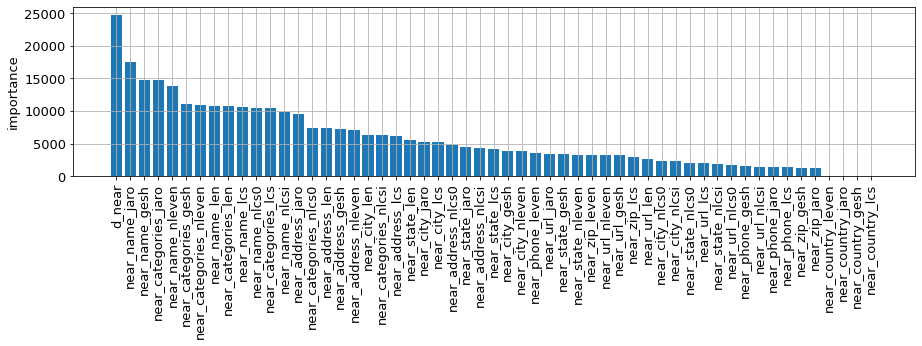

In [ ]:
def plot_importances(models):
    importance_df = pd.DataFrame(models[0].feature_importances_, 
                                 index=features, 
                                 columns=['importance'])\
                        .sort_values("importance", ascending=False)

    plt.subplots(figsize=(len(features) // 4, 5))
    plt.bar(importance_df.index, importance_df.importance)
    plt.grid()
    plt.xticks(rotation=90)
    plt.ylabel("importance")
    plt.tight_layout()
    plt.show()

plot_importances(models)

# Simple Post-Processing

In [ ]:
import optuna
from copy import deepcopy

def objective(trial):
    x = trial.suggest_uniform('threshold', 0, 1)
    id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > x)].groupby('id')['near_id'].apply(lambda x: set(x))
    train["matches"] = train["id"]
    if len(id2ids) > 0:
        train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
    id2match = dict(zip(train["id"].values, train["matches"].str.split()))

    for match in tqdm(train["matches"]):
        match = match.split()
        if len(match) == 1:
            continue

        base = match[0]
        for m in match[1:]:
            if not base in id2match[m]:
                id2match[m].append(base)
    id2ids = deepcopy(id2match)
    for id, ids in id2ids.items():
        id2ids[id] = set(ids)
    score, precision, recall = get_score(id2ids)
    print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2022-05-14 13:35:50,922] A new study created in memory with name: no-name-49c7d436-3c5f-423f-95ae-4ac3f0416fc3


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:36:46,285] Trial 0 finished with value: 0.7873576661241363 and parameters: {'threshold': 0.9392210248289898}. Best is trial 0 with value: 0.7873576661241363.


CV: 0.787358, precision: 0.996013, recall: 0.790592


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:38:12,314] Trial 1 finished with value: 0.8029357848467249 and parameters: {'threshold': 0.17067172321291768}. Best is trial 1 with value: 0.8029357848467249.


CV: 0.802936, precision: 0.925504, recall: 0.865427


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.823822, precision: 0.977732, recall: 0.842533


[I 2022-05-14 13:39:32,180] Trial 2 finished with value: 0.8238218037366978 and parameters: {'threshold': 0.6104991183820389}. Best is trial 2 with value: 0.8238218037366978.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:41:02,447] Trial 3 finished with value: 0.8155756265645143 and parameters: {'threshold': 0.2793233448338748}. Best is trial 2 with value: 0.8238218037366978.


CV: 0.815576, precision: 0.946597, recall: 0.860613


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:42:38,081] Trial 4 finished with value: 0.7849697288534406 and parameters: {'threshold': 0.09480407712021355}. Best is trial 2 with value: 0.8238218037366978.


CV: 0.784970, precision: 0.898906, recall: 0.868824


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:43:58,034] Trial 5 finished with value: 0.8078133150162866 and parameters: {'threshold': 0.8572790176411994}. Best is trial 2 with value: 0.8238218037366978.


CV: 0.807813, precision: 0.991734, recall: 0.814627


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:45:20,536] Trial 6 finished with value: 0.8240613582146425 and parameters: {'threshold': 0.5922970053380081}. Best is trial 6 with value: 0.8240613582146425.


CV: 0.824061, precision: 0.976520, recall: 0.843802


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:46:39,496] Trial 7 finished with value: 0.8085976774810283 and parameters: {'threshold': 0.8517097045577253}. Best is trial 6 with value: 0.8240613582146425.


CV: 0.808598, precision: 0.991440, recall: 0.815657


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.823824, precision: 0.977736, recall: 0.842531


[I 2022-05-14 13:47:59,623] Trial 8 finished with value: 0.8238240115783995 and parameters: {'threshold': 0.6105439321594074}. Best is trial 6 with value: 0.8240613582146425.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:49:23,345] Trial 9 finished with value: 0.8239987092509001 and parameters: {'threshold': 0.4824884572226441}. Best is trial 6 with value: 0.8240613582146425.


CV: 0.823999, precision: 0.968453, recall: 0.850623


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.822941, precision: 0.963594, recall: 0.853705


[I 2022-05-14 13:50:49,674] Trial 10 finished with value: 0.8229405211853437 and parameters: {'threshold': 0.42564229164262285}. Best is trial 6 with value: 0.8240613582146425.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:52:12,506] Trial 11 finished with value: 0.8243108399787865 and parameters: {'threshold': 0.5221234444826706}. Best is trial 11 with value: 0.8243108399787865.


CV: 0.824311, precision: 0.971577, recall: 0.848258


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:53:33,574] Trial 12 finished with value: 0.8217212387886863 and parameters: {'threshold': 0.6845298113477137}. Best is trial 11 with value: 0.8243108399787865.


CV: 0.821721, precision: 0.982346, recall: 0.836496


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:55:00,616] Trial 13 finished with value: 0.8200354858127729 and parameters: {'threshold': 0.34880896841285575}. Best is trial 11 with value: 0.8243108399787865.


CV: 0.820035, precision: 0.955618, recall: 0.857517


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:56:16,970] Trial 14 finished with value: 0.8219145699930186 and parameters: {'threshold': 0.6793963947962273}. Best is trial 11 with value: 0.8243108399787865.


CV: 0.821915, precision: 0.982037, recall: 0.836955


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:57:41,456] Trial 15 finished with value: 0.8244030580739825 and parameters: {'threshold': 0.5386235304213673}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824403, precision: 0.972829, recall: 0.847293


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 13:59:07,822] Trial 16 finished with value: 0.8151889536215428 and parameters: {'threshold': 0.27500513221868117}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.815189, precision: 0.945903, recall: 0.860802


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:00:24,870] Trial 17 finished with value: 0.8175654212605321 and parameters: {'threshold': 0.7630789622645194}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.817565, precision: 0.986785, recall: 0.828570


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:01:52,587] Trial 18 finished with value: 0.8230475180884373 and parameters: {'threshold': 0.4307342446770621}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.823048, precision: 0.964050, recall: 0.853419


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:03:34,189] Trial 19 finished with value: 0.7421851228149015 and parameters: {'threshold': 0.027469103069688916}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.742185, precision: 0.839500, recall: 0.872400


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:04:57,771] Trial 20 finished with value: 0.8242302031335146 and parameters: {'threshold': 0.5068297317763041}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824230, precision: 0.970401, recall: 0.849187


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.824368, precision: 0.973165, recall: 0.846972


[I 2022-05-14 14:06:22,782] Trial 21 finished with value: 0.8243683299629223 and parameters: {'threshold': 0.5435389921052975}. Best is trial 15 with value: 0.8244030580739825.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:07:47,461] Trial 22 finished with value: 0.8242274098101711 and parameters: {'threshold': 0.5064238522578625}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824227, precision: 0.970373, recall: 0.849205


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:09:14,772] Trial 23 finished with value: 0.8213789313508099 and parameters: {'threshold': 0.379548497952944}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.821379, precision: 0.958961, recall: 0.856041


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:10:36,092] Trial 24 finished with value: 0.824329981294198 and parameters: {'threshold': 0.5520509969230618}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824330, precision: 0.973744, recall: 0.846438


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.820164, precision: 0.984455, recall: 0.833139


[I 2022-05-14 14:11:53,571] Trial 25 finished with value: 0.8201642204755214 and parameters: {'threshold': 0.7207181248498112}. Best is trial 15 with value: 0.8244030580739825.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:13:15,496] Trial 26 finished with value: 0.8242877890393677 and parameters: {'threshold': 0.5600418396246555}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824288, precision: 0.974300, recall: 0.845921


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:14:31,887] Trial 27 finished with value: 0.8152519218479785 and parameters: {'threshold': 0.7937430467933677}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.815252, precision: 0.988469, recall: 0.824821


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:15:59,764] Trial 28 finished with value: 0.8171215455868133 and parameters: {'threshold': 0.30043210911916013}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.817122, precision: 0.949609, recall: 0.859661


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:17:02,433] Trial 29 finished with value: 0.7315097287521137 and parameters: {'threshold': 0.9928593759461108}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.731510, precision: 0.999354, recall: 0.732036


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:18:22,313] Trial 30 finished with value: 0.8227466313646535 and parameters: {'threshold': 0.6555767399312751}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.822747, precision: 0.980621, recall: 0.839003


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:19:43,301] Trial 31 finished with value: 0.8243761467576184 and parameters: {'threshold': 0.5456960392569598}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824376, precision: 0.973339, recall: 0.846831


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:21:06,567] Trial 32 finished with value: 0.8232687960388446 and parameters: {'threshold': 0.4408104735501659}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.823269, precision: 0.964938, recall: 0.852880


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:22:28,871] Trial 33 finished with value: 0.8242410494996086 and parameters: {'threshold': 0.572777816615201}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824241, precision: 0.975208, recall: 0.845104


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:23:47,144] Trial 34 finished with value: 0.8233679800297256 and parameters: {'threshold': 0.6323482572755037}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.823368, precision: 0.979153, recall: 0.840874


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:25:10,854] Trial 35 finished with value: 0.824330490783297 and parameters: {'threshold': 0.5524997626362405}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824330, precision: 0.973773, recall: 0.846413


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:26:41,416] Trial 36 finished with value: 0.8026195942957987 and parameters: {'threshold': 0.16888321540017848}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.802620, precision: 0.925023, recall: 0.865500


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:27:57,532] Trial 37 finished with value: 0.821729070496792 and parameters: {'threshold': 0.3884557303301517}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.821729, precision: 0.959913, recall: 0.855591


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:29:11,487] Trial 38 finished with value: 0.823858630929949 and parameters: {'threshold': 0.47318108080114485}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.823859, precision: 0.967706, recall: 0.851110


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.819116, precision: 0.985553, recall: 0.831157


[I 2022-05-14 14:30:17,249] Trial 39 finished with value: 0.8191159831349497 and parameters: {'threshold': 0.740025305622418}. Best is trial 15 with value: 0.8244030580739825.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:31:31,196] Trial 40 finished with value: 0.8114483155057703 and parameters: {'threshold': 0.8298353373795104}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.811448, precision: 0.990347, recall: 0.819424


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:32:41,842] Trial 41 finished with value: 0.8243805148263744 and parameters: {'threshold': 0.5459504785573122}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824381, precision: 0.973357, recall: 0.846818


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:33:52,298] Trial 42 finished with value: 0.8234745756465179 and parameters: {'threshold': 0.6288623442996983}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.823475, precision: 0.978932, recall: 0.841166


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:35:01,903] Trial 43 finished with value: 0.8241150921768199 and parameters: {'threshold': 0.5870604109978426}. Best is trial 15 with value: 0.8244030580739825.


CV: 0.824115, precision: 0.976160, recall: 0.844159


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:36:14,726] Trial 44 finished with value: 0.824404161049442 and parameters: {'threshold': 0.539712006028612}. Best is trial 44 with value: 0.824404161049442.


CV: 0.824404, precision: 0.972905, recall: 0.847230


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.823935, precision: 0.968180, recall: 0.850790


[I 2022-05-14 14:37:26,418] Trial 45 finished with value: 0.8239348600786851 and parameters: {'threshold': 0.47904174174072567}. Best is trial 44 with value: 0.824404161049442.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:38:32,207] Trial 46 finished with value: 0.8216191045789423 and parameters: {'threshold': 0.6882898228570504}. Best is trial 44 with value: 0.824404161049442.


CV: 0.821619, precision: 0.982591, recall: 0.836186


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:39:42,433] Trial 47 finished with value: 0.8243851936119754 and parameters: {'threshold': 0.528878566265439}. Best is trial 44 with value: 0.824404161049442.


CV: 0.824385, precision: 0.972101, recall: 0.847889


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:40:59,685] Trial 48 finished with value: 0.8185833087594067 and parameters: {'threshold': 0.32310167142290025}. Best is trial 44 with value: 0.824404161049442.


CV: 0.818583, precision: 0.952493, recall: 0.858699


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:42:11,393] Trial 49 finished with value: 0.8235246590016254 and parameters: {'threshold': 0.452643678303343}. Best is trial 44 with value: 0.824404161049442.


CV: 0.823525, precision: 0.965972, recall: 0.852260


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:43:25,572] Trial 50 finished with value: 0.821569911551007 and parameters: {'threshold': 0.3845400700734841}. Best is trial 44 with value: 0.824404161049442.


CV: 0.821570, precision: 0.959475, recall: 0.855796


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:44:36,768] Trial 51 finished with value: 0.8242199908294595 and parameters: {'threshold': 0.5097679118535576}. Best is trial 44 with value: 0.824404161049442.


CV: 0.824220, precision: 0.970598, recall: 0.849007


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:45:52,376] Trial 52 finished with value: 0.8244107941576181 and parameters: {'threshold': 0.5378077597473033}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824411, precision: 0.972775, recall: 0.847344


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:47:06,884] Trial 53 finished with value: 0.8235259373179488 and parameters: {'threshold': 0.6265543706537363}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823526, precision: 0.978795, recall: 0.841328


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:48:15,515] Trial 54 finished with value: 0.8239460120289203 and parameters: {'threshold': 0.6019513260383083}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823946, precision: 0.977140, recall: 0.843160


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:49:24,758] Trial 55 finished with value: 0.8243414669084216 and parameters: {'threshold': 0.5242779132151932}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824341, precision: 0.971746, recall: 0.848148


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:50:36,407] Trial 56 finished with value: 0.8223523359871608 and parameters: {'threshold': 0.6674658869998477}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.822352, precision: 0.981323, recall: 0.838004


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:51:49,789] Trial 57 finished with value: 0.8223610403025787 and parameters: {'threshold': 0.4073439017784335}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.822361, precision: 0.961826, recall: 0.854619


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.812778, precision: 0.941531, recall: 0.862045


[I 2022-05-14 14:53:10,902] Trial 58 finished with value: 0.8127777356679794 and parameters: {'threshold': 0.24794083815443507}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.823591, precision: 0.966360, recall: 0.851996


[I 2022-05-14 14:54:22,920] Trial 59 finished with value: 0.8235914155737475 and parameters: {'threshold': 0.45728930180550276}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:55:34,125] Trial 60 finished with value: 0.8240590823496978 and parameters: {'threshold': 0.5912653468300156}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824059, precision: 0.976452, recall: 0.843859


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:56:47,834] Trial 61 finished with value: 0.8243884534719772 and parameters: {'threshold': 0.5301504328296924}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824388, precision: 0.972196, recall: 0.847814


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:58:02,097] Trial 62 finished with value: 0.8243424328391659 and parameters: {'threshold': 0.5243697926806279}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824342, precision: 0.971751, recall: 0.848144


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 14:59:14,781] Trial 63 finished with value: 0.824177323633761 and parameters: {'threshold': 0.495396759387922}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824177, precision: 0.969516, recall: 0.849892


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:00:26,000] Trial 64 finished with value: 0.824400092485673 and parameters: {'threshold': 0.5405492799550736}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824400, precision: 0.972957, recall: 0.847180


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:01:41,379] Trial 65 finished with value: 0.8238327538097632 and parameters: {'threshold': 0.47173848049711886}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823833, precision: 0.967581, recall: 0.851190


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.820833, precision: 0.983701, recall: 0.834452


[I 2022-05-14 15:02:48,580] Trial 66 finished with value: 0.8208331926317312 and parameters: {'threshold': 0.7069853916369063}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:04:04,354] Trial 67 finished with value: 0.8201511550417212 and parameters: {'threshold': 0.351240698107709}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.820151, precision: 0.955887, recall: 0.857401


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:05:15,616] Trial 68 finished with value: 0.8242685897868877 and parameters: {'threshold': 0.5700097980152214}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824269, precision: 0.975021, recall: 0.845287


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:06:22,935] Trial 69 finished with value: 0.8230158620227566 and parameters: {'threshold': 0.6470745647712867}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823016, precision: 0.980118, recall: 0.839693


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:07:36,280] Trial 70 finished with value: 0.823051659542516 and parameters: {'threshold': 0.4310569369535788}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823052, precision: 0.964077, recall: 0.853400


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:08:47,813] Trial 71 finished with value: 0.8243333606579643 and parameters: {'threshold': 0.5518985675226261}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824333, precision: 0.973731, recall: 0.846453


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:09:59,488] Trial 72 finished with value: 0.8243108077409778 and parameters: {'threshold': 0.5209665873725713}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824311, precision: 0.971491, recall: 0.848333


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:11:13,363] Trial 73 finished with value: 0.823910948831834 and parameters: {'threshold': 0.604458939220683}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823911, precision: 0.977303, recall: 0.842983


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.824411, precision: 0.972640, recall: 0.847459


[I 2022-05-14 15:12:26,524] Trial 74 finished with value: 0.8244106882997205 and parameters: {'threshold': 0.5360276785512914}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:13:40,662] Trial 75 finished with value: 0.8240636589807561 and parameters: {'threshold': 0.48613222430244923}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824064, precision: 0.968754, recall: 0.850426


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:14:53,466] Trial 76 finished with value: 0.824196487298441 and parameters: {'threshold': 0.575982134553659}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824196, precision: 0.975400, recall: 0.844896


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.824410, precision: 0.972644, recall: 0.847456


[I 2022-05-14 15:16:07,349] Trial 77 finished with value: 0.8244097669169929 and parameters: {'threshold': 0.5360992122579127}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.822516, precision: 0.962274, recall: 0.854399


[I 2022-05-14 15:17:20,991] Trial 78 finished with value: 0.822516317832616 and parameters: {'threshold': 0.41190553408537167}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:18:30,262] Trial 79 finished with value: 0.8237385804386879 and parameters: {'threshold': 0.6170857848784945}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823739, precision: 0.978193, recall: 0.842052


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:19:41,451] Trial 80 finished with value: 0.8243355301030568 and parameters: {'threshold': 0.5266235891222573}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824336, precision: 0.971913, recall: 0.848000


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:20:53,569] Trial 81 finished with value: 0.8243955201163756 and parameters: {'threshold': 0.5370523533251127}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824396, precision: 0.972715, recall: 0.847379


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:22:09,157] Trial 82 finished with value: 0.8242311693307609 and parameters: {'threshold': 0.5743674729315967}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824231, precision: 0.975309, recall: 0.845009


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:23:23,655] Trial 83 finished with value: 0.8241839604677548 and parameters: {'threshold': 0.4967146915856866}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824184, precision: 0.969617, recall: 0.849810


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.823587, precision: 0.966391, recall: 0.851966


[I 2022-05-14 15:24:38,714] Trial 84 finished with value: 0.8235871175793339 and parameters: {'threshold': 0.45775912638664734}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:25:51,129] Trial 85 finished with value: 0.8243754632104459 and parameters: {'threshold': 0.5443969553987013}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824375, precision: 0.973240, recall: 0.846917


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:27:01,893] Trial 86 finished with value: 0.8230679187611842 and parameters: {'threshold': 0.64418079670012}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823068, precision: 0.979923, recall: 0.839912


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:28:13,017] Trial 87 finished with value: 0.824211944469425 and parameters: {'threshold': 0.5102842500094364}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824212, precision: 0.970634, recall: 0.848966


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:29:21,192] Trial 88 finished with value: 0.8239194964076505 and parameters: {'threshold': 0.6032493622793309}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823919, precision: 0.977221, recall: 0.843063


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:30:35,369] Trial 89 finished with value: 0.8244063787466953 and parameters: {'threshold': 0.53621548272267}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824406, precision: 0.972652, recall: 0.847445


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.823995, precision: 0.968410, recall: 0.850656


[I 2022-05-14 15:31:47,061] Trial 90 finished with value: 0.8239945504428493 and parameters: {'threshold': 0.4819492291429}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:32:59,808] Trial 91 finished with value: 0.8243891044395564 and parameters: {'threshold': 0.5311515209170579}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824389, precision: 0.972271, recall: 0.847749


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:34:09,711] Trial 92 finished with value: 0.8242939200404433 and parameters: {'threshold': 0.5624774236763301}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824294, precision: 0.974488, recall: 0.845770


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.824407, precision: 0.972525, recall: 0.847551


[I 2022-05-14 15:35:22,882] Trial 93 finished with value: 0.8244066678659936 and parameters: {'threshold': 0.5344655116745779}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.824136, precision: 0.975799, recall: 0.844492


[I 2022-05-14 15:36:33,447] Trial 94 finished with value: 0.8241359931029691 and parameters: {'threshold': 0.5817390950115007}. Best is trial 52 with value: 0.8244107941576181.


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:37:49,789] Trial 95 finished with value: 0.8235895805948225 and parameters: {'threshold': 0.4576106730671094}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823590, precision: 0.966379, recall: 0.851977


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:39:06,617] Trial 96 finished with value: 0.8241888855474296 and parameters: {'threshold': 0.5012239994146106}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824189, precision: 0.969937, recall: 0.849531


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:40:18,389] Trial 97 finished with value: 0.8230198400929413 and parameters: {'threshold': 0.4301112304377257}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823020, precision: 0.963979, recall: 0.853451


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:41:27,310] Trial 98 finished with value: 0.8237761830593061 and parameters: {'threshold': 0.6135467337994062}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.823776, precision: 0.977956, recall: 0.842295


  0%|          | 0/10248613 [00:00<?, ?it/s]

[I 2022-05-14 15:42:39,527] Trial 99 finished with value: 0.8243793226208239 and parameters: {'threshold': 0.5456413265702413}. Best is trial 52 with value: 0.8244107941576181.


CV: 0.824379, precision: 0.973337, recall: 0.846836


In [ ]:
threshold = study.best_params['threshold']
threshold

0.5378077597473033

In [ ]:
study.best_value

0.8244107941576181

In [ ]:
id2ids = train[(train["pred"] == train["max_pred"]) & (train["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
train["matches"] = train["id"]
if len(id2ids) > 0:
    train.loc[train["id"].isin(id2ids.keys()), "matches"] += " " + train.loc[train["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(train["id"].values, train["matches"].str.split()))

for match in tqdm(train["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)
id2ids = deepcopy(id2match)
for id, ids in id2ids.items():
    id2ids[id] = set(ids)
score, precision, recall = get_score(id2ids)
print(f"CV: {score:.6f}, precision: {precision:.6f}, recall: {recall:.6f}")

  0%|          | 0/10248613 [00:00<?, ?it/s]

CV: 0.824411, precision: 0.972775, recall: 0.847344


# Submit

In [ ]:
test["pred"] = pred[:, 1]

In [ ]:
test["max_pred"] = test["id"].map(dict(test.groupby("id")["pred"].max()))

In [ ]:
ssub = pd.read_csv("../Input/sample_submission.csv")
ssub = ssub.drop(columns="matches")
id2ids = test[(test["pred"] == test["max_pred"]) & (test["pred"] > threshold)].groupby('id')['near_id'].apply(lambda x: set(x))
ssub["matches"] = ssub["id"]
if len(id2ids) > 0:
    ssub.loc[ssub["id"].isin(id2ids.keys()), "matches"] += " " + ssub.loc[ssub["id"].isin(id2ids.keys()), "id"].map(id2ids).map(lambda x: " ".join(x))
id2match = dict(zip(ssub["id"].values, ssub["matches"].str.split()))

for match in tqdm(ssub["matches"]):
    match = match.split()
    if len(match) == 1:
        continue

    base = match[0]
    for m in match[1:]:
        if not base in id2match[m]:
            id2match[m].append(base)

ssub["matches"] = ssub["id"].map(id2match).map(lambda x: " ".join(x))
ssub.to_csv(os.path.join(OUTPUT_DIR, os.path.join(CFG.expID, "submission.csv")), index=False)

ssub.head()

  0%|          | 0/5 [00:00<?, ?it/s]

,id,matches
0,E_00001118ad0191,E_00001118ad0191
1,E_000020eb6fed40,E_000020eb6fed40
2,E_00002f98667edf,E_00002f98667edf
3,E_001b6bad66eb98,E_001b6bad66eb98 E_0283d9f61e569d
4,E_0283d9f61e569d,E_0283d9f61e569d E_001b6bad66eb98
